In [256]:
!activate tf_gpu

In [257]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

In [258]:
cifar10FolderPath = 'cifar-10-batches-py'

In [259]:
class DLProg(tqdm):
    nthblock = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.nthblock) * block_size)
        self.nthblock = block_num

In [260]:
# try not running this again lmao

if not isfile('cifar-10-python.tar.gz'):
    with DLProg(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                   'cifar-10-python.tar.gz',
                   pbar.hook)
        
if not isdir(cifar10FolderPath):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [261]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [262]:
lblnames = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
    'horse', 'ship', 'truck'
]

In [263]:
def cifar10_load_batch(cifar10FolderPath, batch_id):
    with open(cifar10FolderPath + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is latin1
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    lbls = batch['labels']
    
    return features, lbls

In [264]:
def displaystats(cifar10FolderPath, batch_id, sample_id):
    features, lbls = cifar10_load_batch(cifar10FolderPath, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}. {} is out of range.'.format(len(features), batch_id, sample_id))
        return None
    
    print('\nStats of batch #{}'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
#     lblnames = lblnames
    lblcounts = dict(zip(*np.unique(lbls, return_counts=True)))
    
    for key, value in lblcounts.items():
        print('Label Counts of [{}][{}]: {}'.format(key, lblnames[key].upper(), value))
        
    sampleimg = features[sample_id]
    samplelbl = lbls[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Vallue: {} Max Value: {}'.format(sampleimg.min(), sampleimg.max()))
    print('Image - Shape: {}'.format(sampleimg.shape))
    print('Label - Label Id: {} Name: {}'.format(samplelbl, lblnames[samplelbl]))
    
    plt.imshow(sampleimg)


Stats of batch #3
# of Samples: 10000

Label Counts of [0][AIRPLANE]: 994
Label Counts of [1][AUTOMOBILE]: 1042
Label Counts of [2][BIRD]: 965
Label Counts of [3][CAT]: 997
Label Counts of [4][DEER]: 990
Label Counts of [5][DOG]: 1029
Label Counts of [6][FROG]: 978
Label Counts of [7][HORSE]: 1015
Label Counts of [8][SHIP]: 961
Label Counts of [9][TRUCK]: 1029

Example of Image 7000:
Image - Min Vallue: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


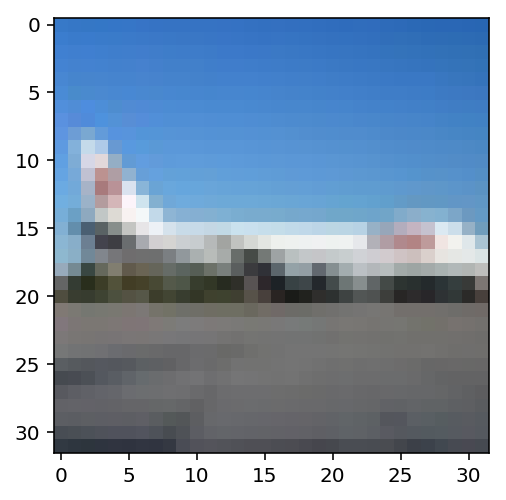

In [265]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batchid = 3
sampleid = 7000
displaystats(cifar10FolderPath, batchid, sampleid)

In [266]:
def normalize(x):
    minv = np.min(x)
    maxv = np.max(x)
    return (x - minv) / (maxv - minv)

In [267]:
def one_hot_encode(x):
    enc = np.zeros((len(x), 10))
    for index, value in enumerate(x):
        enc[index][value] = 1
        
    return enc

In [268]:
def preproc_save(normalize, one_hot_encode, features, lbls, filename):
    features = normalize(features)
    lbls = one_hot_encode(lbls)
    
    pickle.dump((features, lbls), open(filename, 'wb'))

In [269]:
def preproc_save_data(cifar10FolderPath, normalize, one_hot_encode):
    nbatch = 5
    validfeatures = []
    validlbls = []
    
    for batchindex in range(1, nbatch + 1):
        features, lbls = cifar10_load_batch(cifar10FolderPath, batchindex)
        validationindex = int(len(features) * .1)
        preproc_save(normalize, one_hot_encode,
                    features[:-validationindex],
                    lbls[:-validationindex],
                    'preprocess_batch_' + str(batchindex) + '.p')
        
        validfeatures.extend(features[-validationindex:])
        validlbls.extend(lbls[-validationindex:])
        
    preproc_save(normalize, one_hot_encode,
                np.array(validfeatures),
                np.array(validlbls),
                'preprocess_validation.p')
    
    with open(cifar10FolderPath + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
    testfeatures = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    testlbls = batch['labels']
    
    preproc_save(normalize, one_hot_encode, np.array(testfeatures), np.array(testlbls),
                'preprocess.training.p')

In [270]:
# Preprocess data
preproc_save_data(cifar10FolderPath, normalize, one_hot_encode)

In [271]:
import pickle

In [272]:
validfeatures, validlbls = pickle.load(open('preprocess_validation.p', mode='rb'))

In [273]:
import tensorflow as tf

In [274]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='output_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [275]:
def convolution_net(x, keep_prob):
    c1filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=.08))
    c2filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=.08))    
    c3filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=.08))    
    c4filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=.08))
    
    # 1, 2
    c1 = tf.nn.conv2d(x, c1filter, strides=[1, 1, 1, 1], padding='SAME')
    c1 = tf.nn.relu(c1)
    c1pool = tf.nn.max_pool(c1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    c1bn = tf.layers.batch_normalization(c1pool)
    
    # 3, 4
    c2 = tf.nn.conv2d(c1bn, c2filter, strides=[1, 1, 1, 1], padding='SAME')
    c2 = tf.nn.relu(c2)
    c2pool = tf.nn.max_pool(c2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    c2bn = tf.layers.batch_normalization(c2pool)
    
    # 5, 6
    c3 = tf.nn.conv2d(c2bn, c3filter, strides=[1, 1, 1, 1], padding='SAME')
    c3 = tf.nn.relu(c3)
    c3pool = tf.nn.max_pool(c3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    c3bn = tf.layers.batch_normalization(c3pool)
    
    # 7, 8
    c4 = tf.nn.conv2d(c3bn, c4filter, strides=[1, 1, 1, 1], padding='SAME')
    c4 = tf.nn.relu(c4)
    c4pool = tf.nn.max_pool(c4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    c4bn = tf.layers.batch_normalization(c4pool)
    
    # 9
    flat = tf.contrib.layers.flatten(c4bn)
    
    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 11
    full3 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)
    
    # 12
    full4 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)
    
    # 13
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out



In [276]:
epochs = 10
batch_size = 60
keep_probability = .7
learning_rate = .001

In [277]:
logits = convolution_net(x, keep_prob)
model = tf.identity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [278]:
def train_nn(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer,
               feed_dict={
                   x: feature_batch,
                   y: label_batch,
                   keep_prob: keep_probability
               })

In [279]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost,
                   feed_dict = {
                       x: feature_batch,
                       y: label_batch,
                       keep_prob: 1.
                   })
    
    valid_acc = sess.run(accuracy,
                        feed_dict = {
                            x: validfeatures,
                            y: validlbls,
                            keep_prob: 1.
                        }) 
    
    print('Loss: {:>10.4f} Validation Accuracy: {}:.6f'.format(loss, valid_acc))

In [280]:
def batch_features_lbl(features, lbls, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], lbls[start:end]

In [281]:
def load_preproc_train_batch(batch_id, batch_size):
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, lbls = pickle.load(open(filename, mode='rb'))
    
    return batch_features_lbl(features, lbls, batch_size)

In [282]:
save_model_path = './image_classification'

print('Training!...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        nbatch = 5
        for batchindex in range(1, nbatch + 1):
            for batchfeatures, batchlbls in load_preproc_train_batch(batchindex, batch_size):
                train_nn(sess, optimizer, keep_probability, batchfeatures, batchlbls)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:'.format(epoch + 1, batchindex), end='')
            print_stats(sess, batchfeatures, batchlbls, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training!...
Epoch  1, CIFAR-10 Batch 1:Loss:     1.7295 Validation Accuracy: 0.3912000060081482:.6f
Epoch  1, CIFAR-10 Batch 2:Loss:     1.3084 Validation Accuracy: 0.5004000067710876:.6f
Epoch  1, CIFAR-10 Batch 3:Loss:     0.9758 Validation Accuracy: 0.5609999895095825:.6f
Epoch  1, CIFAR-10 Batch 4:Loss:     1.0290 Validation Accuracy: 0.5654000043869019:.6f
Epoch  1, CIFAR-10 Batch 5:Loss:     0.9476 Validation Accuracy: 0.626800000667572:.6f
Epoch  2, CIFAR-10 Batch 1:Loss:     1.2048 Validation Accuracy: 0.6394000053405762:.6f
Epoch  2, CIFAR-10 Batch 2:Loss:     0.9207 Validation Accuracy: 0.6394000053405762:.6f
Epoch  2, CIFAR-10 Batch 3:Loss:     0.5891 Validation Accuracy: 0.6696000099182129:.6f
Epoch  2, CIFAR-10 Batch 4:Loss:     0.6824 Validation Accuracy: 0.6940000057220459:.6f
Epoch  2, CIFAR-10 Batch 5:Loss:     0.4722 Validation Accuracy: 0.7034000158309937:.6f
Epoch  3, CIFAR-10 Batch 1:Loss:     0.8134 Validation Accuracy: 0.6970000267028809:.6f
Epoch  3, CIFAR-10 B

### Checkpoint

The model has been saved to disk.

### Test Model

In [283]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [284]:
def batch_features_lbl(features, lbls, batch_size):
    '''
    Split features and labels into batches
    '''
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], lbls[start:end]

In [289]:
def display_img_predict(features, lbls, predictions, top_n_predictions):
    nclasses = 10
    lblbinarizer = LabelBinarizer()
    lblbinarizer.fit(range(nclasses))
    lblids = lblbinarizer.inverse_transform(np.array(lbls))
    
    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)
    
    n_predictions = 5
    margin = .05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
    
    for image_i, (feature, lblid, pred_indices, pred_values) in enumerate(zip(features, lblids, predictions.indices, predictions.values)):
        if (image_i < top_n_predictions):
            pred_names = [lblnames[pred_i] for pred_i in pred_indices]
            correct_name = lblnames[lblid]
            
            axies[image_i][0].imshow((feature * 255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()
            
            axies[image_i][1].barh(ind + margin, pred_values[:5], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[::1])
            axies[image_i][1].set_xticks([0, .5, 1.])

        

In [290]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

In [291]:
save_model_path = './image_classification'
batch_size = 64
nsamples =10
top_n_predictions = 5

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7218351910828026



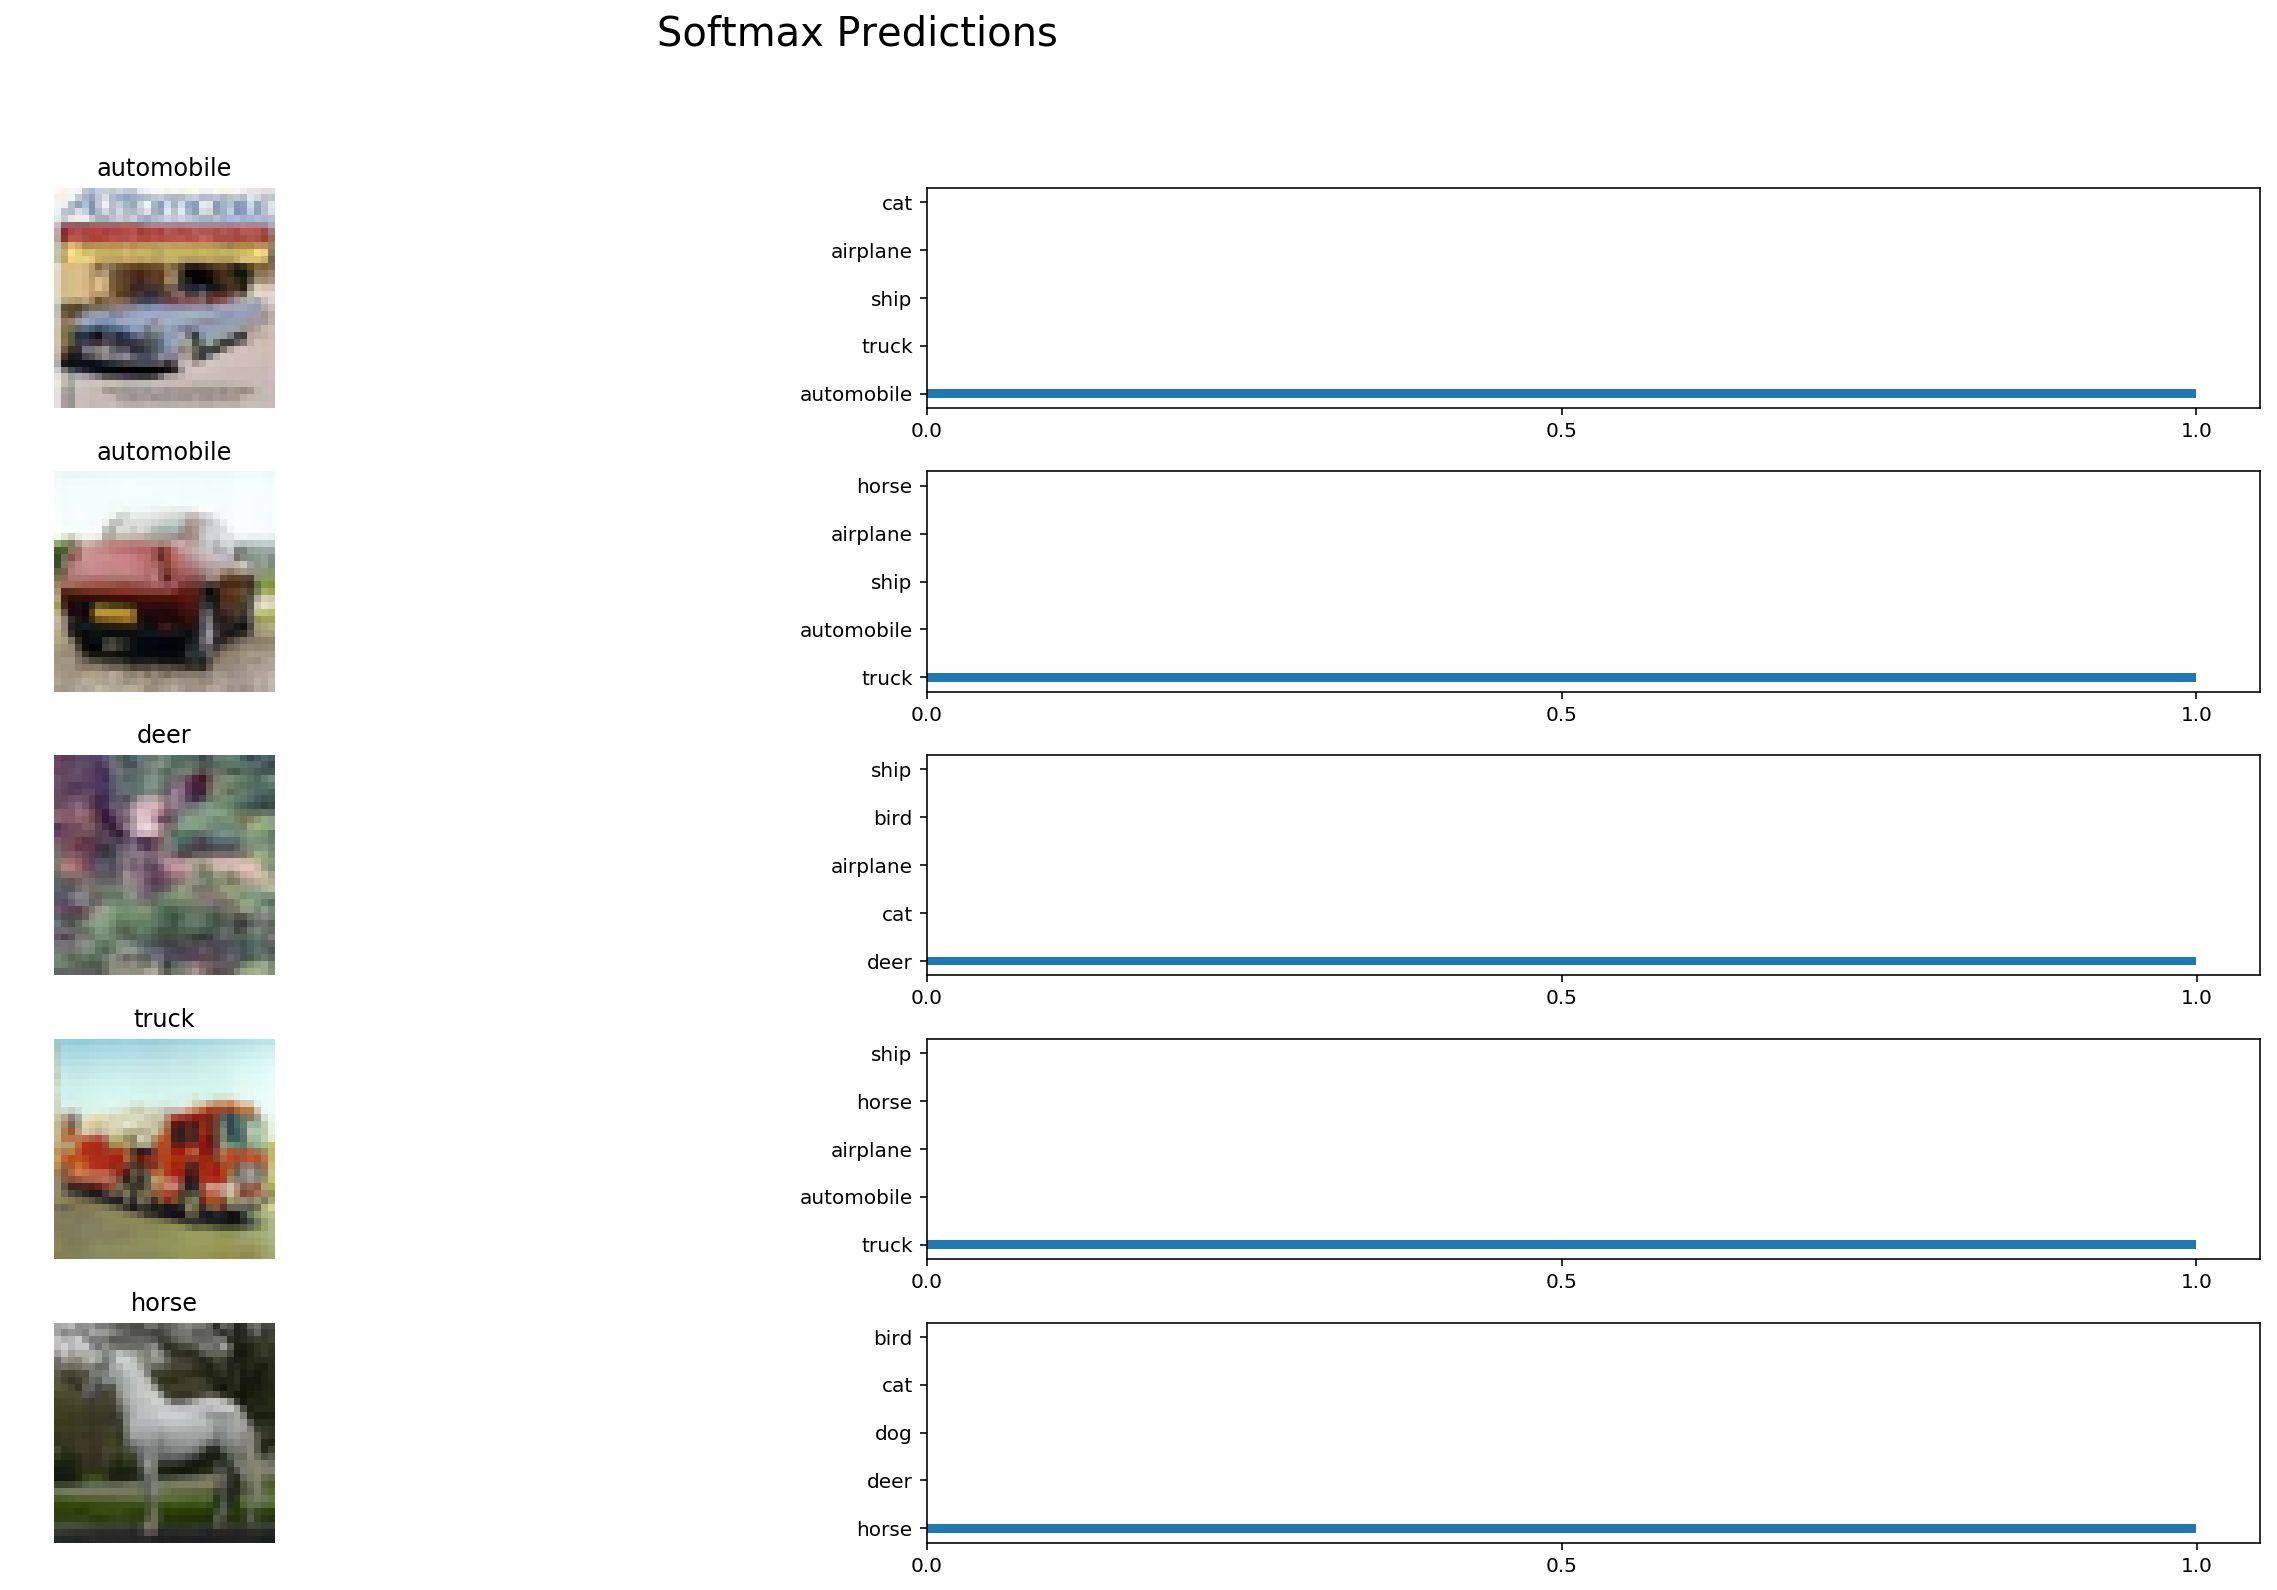

In [292]:
def testmodel():
    testfeatures, testlbls = pickle.load(open('preprocess.training.p', mode='rb'))
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get Tensors from Loaded model
        loadedx = loaded_graph.get_tensor_by_name('output_x:0')
        loadedy = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_lbl(testfeatures, testlbls, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loadedx: train_feature_batch,
                          loadedy: train_label_batch,
                           loaded_keep_prob: 1.
                          })
            test_batch_count += 1
            
        print('Testing Accuracy: {}\n'.format(test_batch_acc_total / test_batch_count))
        
        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(testfeatures, testlbls)), nsamples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict = {loadedx: random_test_features,
                        loadedy: random_test_labels,
                        loaded_keep_prob: 1.})
        display_img_predict(random_test_features, random_test_labels, random_test_predictions, top_n_predictions)
        
testmodel()
            
            
            
            
            
            